In [59]:
import random
from deap import base, creator, tools
from metrics import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt

In [60]:
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0, -1.0, -1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti, id=str) 
toolbox = base.Toolbox()

In [61]:
# Dummy Data
new_domain_names = ['D1', 'D2', 'D3']

initial_population = {
    'D1': 'TTTT',
    'D2': 'TTTT',
    'D3': 'TTTT'
}

domain_appearances = {
    'D1': [0, 1],
    'D2': [1],
    'D3': [0, 2]
}

strand_structures = [
    'D1 D3',
    'D1 D2',
    'D3'
]

In [62]:
def evaluate(domain_individual):
    # Get the current sequence of the domain
    domain_sequence = ''.join(domain_individual)

    # Retrieve the IDs of the strands where this domain appears
    strand_ids = domain_appearances[domain_individual.id]

    # For each strand ID, reconstruct the strand using the current sequences of its constituent domains
    total_scores = [0, 0, 0, 0, 0, 0]
    for strand_id in strand_ids:
        strand_structure = strand_structures[strand_id]
        reconstructed_strand = ''.join([initial_population[dom_name] for dom_name in strand_structure.split()])
        
        # Evaluate the performance of the reconstructed strand
        stability = compute_stability(reconstructed_strand)
        secondary_structures = check_secondary_structures(reconstructed_strand)
        lcs_value = 0  # Placeholder
        cross_hybridization = 0  # Placeholder
        palindrome_score = check_if_palindrome(reconstructed_strand)
        gc_content_score = check_gc_content(reconstructed_strand)
        
        # Combine the scores from all strands for an overall evaluation of the domain
        scores = [lcs_value, stability, secondary_structures, cross_hybridization, palindrome_score, gc_content_score]
        total_scores = [sum(x) for x in zip(total_scores, scores)]

    # Average the scores over all strands
    average_scores = [score / len(strand_ids) for score in total_scores]
    return tuple(average_scores)


In [63]:
def variable_length_crossover(parent1, parent2):
        if len(parent1) < len(parent2):
            shorter, longer = parent1, parent2
        else:
            shorter, longer = parent2, parent1
        
        crossover_point = random.randint(0, len(shorter) - 1)
        offspring1_data = longer[:len(longer) - len(shorter) + crossover_point] + shorter[crossover_point:]
        offspring2_data = shorter[:crossover_point] + longer[len(longer) - len(shorter) + crossover_point:len(longer) - len(shorter) + len(shorter)]
        
        offspring1 = creator.Individual(offspring1_data)
        offspring2 = creator.Individual(offspring2_data)
        
        if len(offspring1) == len(parent1):
            offspring1.id = parent1.id
            offspring2.id = parent2.id
        else:
            offspring1.id = parent2.id
            offspring2.id = parent1.id
        
        return offspring1, offspring2

In [64]:
def mutate_sequence(individual):
        mutation_point = random.randint(0, len(individual) - 1)
        available_bases = set(["A", "T", "C", "G"]) - {individual[mutation_point]}
        individual[mutation_point] = random.choice(list(available_bases))
        return individual,

In [65]:
toolbox.register("evaluate", evaluate)
toolbox.register("mate", variable_length_crossover)
toolbox.register("mutate", mutate_sequence)
toolbox.register("select", tools.selNSGA2)
avg_fitness_over_generations = []

In [66]:
def run(generations):
    # Define the initial population
    population = [creator.Individual(list(sequence)) for domain_name, sequence in initial_population.items()]
    for domain_name, individual in zip(initial_population.keys(), population):
        individual.id = domain_name

    # Extract all domains from the population that appear in strands
    relevant_population = [individual for individual in population if domain_appearances[individual.id]]

    # Evaluate the relevant population
    fitnesses = list(map(toolbox.evaluate, relevant_population))
    for ind, fit in zip(relevant_population, fitnesses):
        ind.fitness.values = fit

    # Run the genetic algorithm using the filtered population
    for gen in range(generations):
        offspring = toolbox.select(relevant_population, len(relevant_population))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.7:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < 0.2:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        fitnesses = list(map(toolbox.evaluate, offspring))
        for ind, fit in zip(offspring, fitnesses):
            ind.fitness.values = fit
        avg_fitness = sum(ind.fitness.values[0] for ind in relevant_population) / len(relevant_population)
        avg_fitness_over_generations.append(avg_fitness)
        relevant_population[:] = offspring

    for individual in relevant_population:
        initial_population[individual.id] = ''.join(individual)
        print(individual.id, " = ", individual)

    # Reconstruct the final strands
    final_strands = []
    for strand_structure in strand_structures:
        strand = ''.join([initial_population[dom_name] for dom_name in strand_structure.split()])
        final_strands.append(strand)

    # Extract the evolved domain sequences
    evolved_domain_sequences = [{"name": domain_name, "sequence": sequence} for domain_name, sequence in initial_population.items()]

    return final_strands, evolved_domain_sequences


In [67]:
def plot_fitness_over_generations():
    generations = list(range(len(avg_fitness_over_generations)))
    
    # Plotting the data
    plt.plot(generations, avg_fitness_over_generations)
    
    # Setting the x and y axis labels and title
    plt.xlabel('Generation')
    plt.ylabel('Average Fitness')
    plt.title('Fitness Evolution Over Generations')
    
    # Setting the x and y axis limits
    plt.xlim([0, len(generations)])
    plt.ylim([min(avg_fitness_over_generations) - 1, max(avg_fitness_over_generations) + 1])  # added a buffer of 1 for clarity
    
    # Adjusting the tick intervals (if needed)
    # plt.xticks(np.arange(0, len(generations), step=10))
    # plt.yticks(np.arange(min(avg_fitness_over_generations), max(avg_fitness_over_generations) + 1, step=0.5))
    
    plt.show()


D1  =  ['T', 'T', 'C', 'C']
D2  =  ['T', 'T', 'T', 'C']
D3  =  ['T', 'T', 'T', 'T']


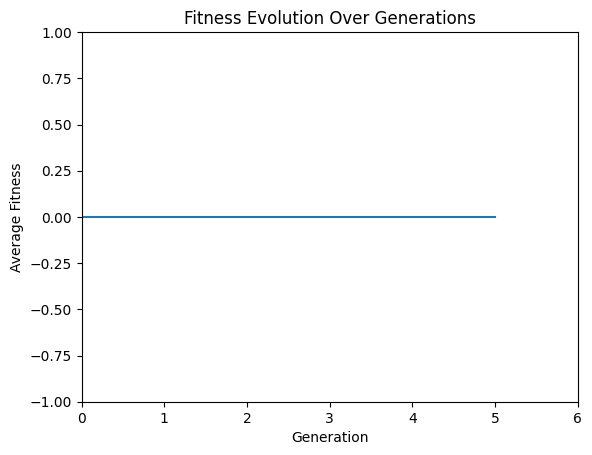

In [68]:

# Creating the NSGA object
generations = 6
run(generations)
plot_fitness_over_generations()

